In [905]:
import pandas as pd
import numpy as np

from scipy.stats import shapiro, levene, f_oneway
import scikit_posthocs as sp

import matplotlib.pyplot as plt

df = pd.read_csv('./static/result.csv')
df.head()

length = [*range(1,25)]

replacement_ans = {
    "Agree": 1,
    "Unsure": 0,
    "Disagree": -1,
}

replacement_conf = {
    "7-Extremely confident": 7,
    "6-Very confident": 6,
    "5-Somewhat confident": 5,
    "4-Neutral": 4,
    "3-Somewhat lacking confidence": 3,
    "2-Very lacking confidence": 2,
    "1-Extremely lacking confidence": 1,
}

condition = [
    "control",
    "ai-edited-image",
    "ai-edited-video",
    "ai-edited-image-video",
]

induced_imgs = [1,2,3,4,9,10,11,12,17,18,19,20]
non_induced_imgs = [5,6,7,8,13,14,15,16,21,22,23,24]

correct_is_true = [6,7,9,10,14,18,21,23]
correct_is_false = [1,2,3,4,5,8,11,12,13,15,16,17,19,20,22,24]

# get filtered columns
filtered_cols = [[f"{i}_false_memories_ans", f"{i}_false_memories_conf"] for i in length]
filtered_cols = [i for sublist in filtered_cols for i in sublist]

# remove headers and replace values
head = df.head(1)
df = df[2:][['condition', *filtered_cols]]
df.replace(replacement_ans, inplace=True)
df.replace(replacement_conf, inplace=True)

result = df.copy()
result = result[['condition'] + [f"{i}_false_memories_ans" for i in length]  + [f"{i}_false_memories_conf" for i in length]]

# convert raw answer to score (1 -> correct, 0 -> unsure, -1 -> wrong)
for i in length:
    multiplier = 1 if i in correct_is_true else -1
    result[f"{i}_false_memories_ans"] *= multiplier

/var/folders/bw/64y3yr9n6v50fgm86wtx236c0000gn/T/ipykernel_57860/2451076264.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(replacement_ans, inplace=True)
/var/folders/bw/64y3yr9n6v50fgm86wtx236c0000gn/T/ipykernel_57860/2451076264.py:51: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(replacement_conf, inplace=True)


In [906]:
# Generate Raw Tables

def summarize(cat, df):
    # get sum
    df['overall'] = df[[f"{i}_false_memories_ans" for i in [*range(1,25)]]].sum(axis=1)
    df['induced'] = df[[f"{i}_false_memories_ans" for i in [*range(1,25)] if i in induced_imgs]].sum(axis=1)
    df['non induced'] = df[[f"{i}_false_memories_ans" for i in [*range(1,25) ] if i in non_induced_imgs]].sum(axis=1)

    # get percentages in % in two decimals
    df['overall %'] = (df['overall'] / 24) * 100
    df['induced %'] = (df['induced'] / 12) * 100
    df['non induced %'] = (df['non induced'] / 12) * 100

    # filter
    df = df[['condition', 'overall', 'overall %', 'induced', 'induced %', 'non induced', 'non induced %']]

    print(cat)
    display(df.groupby('condition').mean().round(2))
    
true_memories = result.copy().replace(-1,0)
false_memories = result.copy().replace(1,0).replace(-1,1)
unsure_memories = result.copy().replace(1,-1).replace(0,1).replace(-1,0)

print("AMOUNT")
summarize('Non False Memories', true_memories)
summarize('Unsure Memories', unsure_memories)
summarize('False Memories', false_memories)

def confidence(cat, result, raw):
    print(cat)
    # display(result)
    # display(raw[['condition', *[f"{i}_false_memories_conf" for i in length]]])
    
    # get confidence: for each row {i}_confidence = result[{i}_false_memories_ans] * raw[{i}_false_memories_conf]
    for i in length:
        result[f"{i}_conf"] = result[f"{i}_false_memories_ans"] * raw[f"{i}_false_memories_conf"]
    
    result['overall'] = result[[f"{i}_conf" for i in length]].sum(axis=1) / 14
    result['induced'] = result[[f"{i}_conf" for i in length if i in induced_imgs]].sum(axis=1) / 7
    result['non induced'] = result[[f"{i}_conf" for i in length if i in non_induced_imgs]].sum(axis=1) / 7

    result = result[['condition', 'overall', 'induced', 'non induced']]
    display(result.groupby('condition').mean().round(2))
        
true_memories = result.copy().replace(-1,0)
false_memories = result.copy().replace(1,0).replace(-1,1)

print("\nCONFIDENCE")
confidence("Non False Memories", true_memories, df)
confidence("False Memories", false_memories, df)

AMOUNT
Non False Memories


,overall,overall %,induced,induced %,non induced,non induced %
condition,,,,,,
ai-edited-image,13.65,56.86,6.47,53.92,7.18,59.80
ai-edited-image-video,12.10,50.42,5.26,43.83,6.84,57.00
ai-edited-video,13.82,57.58,6.98,58.17,6.84,57.00
control,15.06,62.76,7.94,66.16,7.12,59.35


Unsure Memories


,overall,overall %,induced,induced %,non induced,non induced %
condition,,,,,,
ai-edited-image,3.61,15.03,1.76,14.71,1.84,15.36
ai-edited-image-video,4.58,19.08,2.10,17.50,2.48,20.67
ai-edited-video,4.28,17.83,2.18,18.17,2.10,17.50
control,3.96,16.50,1.80,14.97,2.16,18.03


False Memories


,overall,overall %,induced,induced %,non induced,non induced %
condition,,,,,,
ai-edited-image,6.75,28.10,3.76,31.37,2.98,24.84
ai-edited-image-video,7.32,30.50,4.64,38.67,2.68,22.33
ai-edited-video,5.90,24.58,2.84,23.67,3.06,25.50
control,4.98,20.75,2.27,18.88,2.71,22.62



CONFIDENCE
Non False Memories


,overall,induced,non induced
condition,,,
ai-edited-image,5.21,4.96,5.47
ai-edited-image-video,4.95,4.23,5.67
ai-edited-video,5.64,5.71,5.56
control,5.98,6.32,5.64


False Memories


,overall,induced,non induced
condition,,,
ai-edited-image,2.42,2.70,2.13
ai-edited-image-video,2.94,3.80,2.09
ai-edited-video,2.22,2.18,2.27
control,1.86,1.74,1.97


In [907]:
score = pd.DataFrame()

# for each row in df, multiply answer by confidence
for i in length:
    multiplier = -1 if i in correct_is_false else 1
    score['condition'] = df['condition']
    score[f"{i}_false_memories_score"] = multiplier * df[f"{i}_false_memories_ans"] * df[f"{i}_false_memories_conf"]
    score[f"{i}_false_memories_no"] = multiplier * df[f"{i}_false_memories_ans"]

# sum scores    
score['overall'] = score[[f"{i}_false_memories_score" for i in length]].sum(axis=1)
score['induced'] = score[[f"{i}_false_memories_no" for i in length if i in induced_imgs]].sum(axis=1)
score['weighted induced'] = score[[f"{i}_false_memories_score" for i in length if i in induced_imgs]].sum(axis=1)
score['non induced'] = score[[f"{i}_false_memories_no" for i in length if i in non_induced_imgs]].sum(axis=1)
score['weighted non induced'] = score[[f"{i}_false_memories_score" for i in length if i in non_induced_imgs]].sum(axis=1)

cond = ['condition', 'overall', 'induced', 'weighted induced', 'non induced', 'weighted non induced']
# score = score[cond + [f"{i}_false_memories_score" for i in length]]
score = score[cond]

# group by condition and average
print(f"score: 1 -> correct (true memory), 0 -> unsure, -1 if wrong (false memory)")
print("weight score: score {1,0,-1} * confidence [1,7] (how strong the memory is)")
print("higher score means less false memory")
score.groupby('condition').mean().round(2)

score: 1 -> correct (true memory), 0 -> unsure, -1 if wrong (false memory)
weight score: score {1,0,-1} * confidence [1,7] (how strong the memory is)
higher score means less false memory


,overall,induced,weighted induced,non induced,weighted non induced
condition,,,,,
ai-edited-image,39.16,2.71,15.80,4.20,23.35
ai-edited-image-video,28.10,0.62,3.04,4.16,25.06
ai-edited-video,47.80,4.14,24.76,3.78,23.04
control,57.76,5.67,32.06,4.41,25.69


In [908]:
# convert score to list based on 'condition'
data = []
conditions = ['control', 'ai-edited-video', 'ai-edited-image', 'ai-edited-image-video']
for c in conditions:
    s = score[score['condition'] == c]['weighted induced']
    data.append(s.tolist())

print("SHAPIRO-WILK")
for i in range(4):
    print(conditions[i], "=>", shapiro(data[i]))

print("\nLEVENE", "=>", levene(*data))

print("ANOVA", "=>", f_oneway(*data))

print("\nTUKEY (weighted score)")
print(sp.posthoc_tukey(data))

# control - 1, ai-edited-video - 2, ai-edited-image - 3, ai-edited-image-video - 4

SHAPIRO-WILK
control => ShapiroResult(statistic=np.float64(0.9608693154405361), pvalue=np.float64(0.10287465901514571))
ai-edited-video => ShapiroResult(statistic=np.float64(0.9777998356545977), pvalue=np.float64(0.4633678705301146))
ai-edited-image => ShapiroResult(statistic=np.float64(0.9777820369607433), pvalue=np.float64(0.4494322220405031))
ai-edited-image-video => ShapiroResult(statistic=np.float64(0.9677447492422139), pvalue=np.float64(0.18709202425588012))

LEVENE => LeveneResult(statistic=np.float64(0.5001481412826619), pvalue=np.float64(0.6826089663897446))
ANOVA => F_onewayResult(statistic=np.float64(14.576926195005388), pvalue=np.float64(1.3120115769723279e-08))

TUKEY (weighted score)
          1         2         3         4
1  1.000000  0.396745  0.002962  0.001000
2  0.396745  1.000000  0.210558  0.001000
3  0.002962  0.210558  1.000000  0.030136
4  0.001000  0.001000  0.030136  1.000000


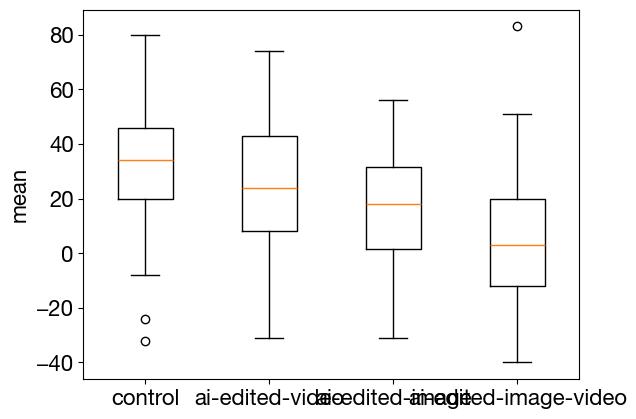

In [909]:
fig, ax = plt.subplots(1, 1)
ax.boxplot(data)
ax.set_xticklabels(conditions) 
ax.set_ylabel("mean") 
plt.show()

In [910]:
# Prepare data for plotting according to the specified order and calculate mean and standard error
means = []
errors = []
sds = []
condition_dict = {
    'control': data[0],
    'ai-edited-video': data[1],
    'ai-edited-image': data[2],
    'ai-edited-image-video': data[3]
}

for condition in conditions:
    if condition in condition_dict:
        values = condition_dict[condition]
        mean = np.mean(values)
        # Calculate the standard error as the error bar (standard deviation divided by the square root of the sample size)
        std = np.std(values)
        error = np.std(values) / np.sqrt(len(values))
        means.append(mean)
        sds.append(std)
        errors.append(error)
        
        print(f"{condition}: ", mean, error, std)
        
# means, errors, sds

control:  32.06122448979592 3.1413206107829135 21.989244275480395
ai-edited-video:  24.76 3.224600440364666 22.801368379989828
ai-edited-image:  15.803921568627452 3.0072345944520706 21.475950624117548
ai-edited-image-video:  3.04 3.526126486670607 24.933479500462827


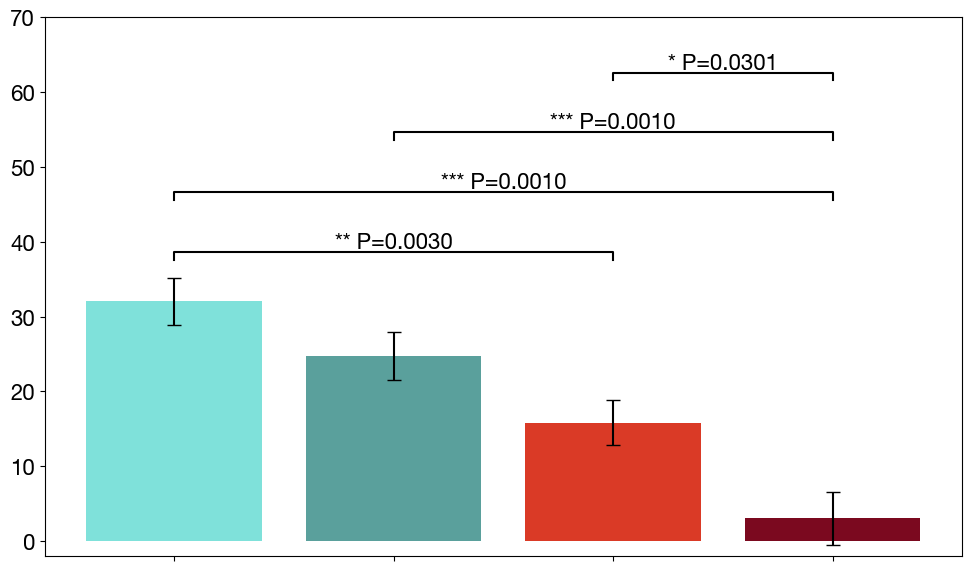

In [911]:
# ordered_labels = ['Unedited Images', 'AI-Generated Videos\nof Unedited Images', 'AI-Edited Images', 'AI-Generated Videos\nof AI-Edited Images']
ordered_labels = ['', '', '', '']
colors = ["#7FE1DA", "#5AA09C", "#DA3A26", "#7B091F"]

# X positions
x_pos = np.arange(len(conditions))

# *    P ≤ 0.05
# **   P ≤ 0.01
# ***  P ≤ 0.001
# **** P ≤ 0.0001

#           1         2         3         4
# 1  1.000000  0.396745  0.002962  0.001000
# 2  0.396745  1.000000  0.210558  0.001000
# 3  0.002962  0.210558  1.000000  0.030136
# 4  0.001000  0.001000  0.030136  1.000000

# Significance values (p-values) for the significance markers
significance_values = [
    ((0, 2), '** P=0.0030'),
    ((0, 3), '*** P=0.0010'),
    ((1, 3), '*** P=0.0010'),
    ((2, 3), '* P=0.0301'),
]

# Creating the bar plot with error bars
plt.figure(figsize=(10, 6))
bars = plt.bar(x_pos, means, yerr=errors, capsize=5, color=colors)
# plt.title('Recollection Score by Experimental Condition with Error Bars')
# plt.ylabel('Average Score')
# plt.xlabel('Experimental Condition')
plt.xticks(x_pos, ordered_labels)

# Adding significance markers with p-values, separate and not overlapping
y_base_offset = 2  # Base vertical offset for significance lines
y_increment = 8  # Increment for each subsequent significance marker

# Initialize the first y position above the highest bar
current_y_position = max(means) + max(errors) + y_base_offset

for idx, ((i, j), label) in enumerate(significance_values):
    x1, x2 = x_pos[i], x_pos[j]
    # print("{1} and {2} with id: {0}".format(idx, x1, x2))
    y = current_y_position
    h, col = 1, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1 + x2) * 0.5, y + h, label, ha='center', va='bottom', color=col)
    current_y_position += y_increment  # Update the y position for the next marker

# Adjust plot limits to make space for significance markers
plt.ylim(-2, 70) # current_y_position + y_increment

# Improve layout
plt.tight_layout()

#plt.savefig('foo.png', bbox_inches='tight')

# Show the plot
plt.show()

In [912]:
result_induced = result[['condition', *[f"{i}_false_memories_ans" for i in length if i in induced_imgs]]]
conf_induced = result[['condition', *[f"{i}_false_memories_conf" for i in length if i in induced_imgs]]]

memories = {
    'control': [],
    'ai-edited-video': [],
    'ai-edited-image': [],
    'ai-edited-image-video': []
}

conf = {
    'control': [],
    'ai-edited-video': [],
    'ai-edited-image': [],
    'ai-edited-image-video': []
}

def tally(l, el):
    return len([*filter(lambda x: x == el, l)])

for i in range(len(result_induced)):
    line = result_induced.iloc[i].tolist()
    true, unsure, false = tally(line, 1), tally(line, 0), tally(line, -1)
    memories[line[0]].append([true, unsure, false])
    
    line_conf = conf_induced.iloc[i].tolist()
    tally_conf = [0,0,0]
    for j in range(1, len(line)):
        if(line[j] == 1):
            tally_conf[0] += int(line_conf[j])
        elif (line[j] == 0):
            tally_conf[1] += int(line_conf[j])
        elif (line[j] == -1):
            tally_conf[2] += int(line_conf[j])

    conf[line[0]].append([i / 12 for i in tally_conf])
    
# map each entry into a triplet of tally information
# # -> [# of non-false, # of unsure, # of false]
# Conf -> [Avg. conf. of non-false, Avg. conf. of unsure, Avg. conf. of false]

In [913]:
print("SHAPIRO-WILK")
for c in conditions:
    print(c, "=>", shapiro(memories[c]))

print("\nLEVENE", "=>", levene(*[memories[c] for c in conditions]))

print(f_oneway(memories['control'], memories['ai-edited-video'], memories['ai-edited-image'], memories['ai-edited-image-video']))
print(f_oneway(conf['control'], conf['ai-edited-video'], conf['ai-edited-image'], conf['ai-edited-image-video']))

print("\nTUKEY (# of recalled memories)")
for i in range(3):
    print(['non-false', 'unsure', 'false'][i])
    print("# accuracy\n", sp.posthoc_tukey([[el[i] for el in memories[c]] for c in conditions]) , "\nconf.\n",
          sp.posthoc_tukey([[el[i] for el in conf[c]] for c in conditions]))
    print()

SHAPIRO-WILK
control => ShapiroResult(statistic=np.float64(0.9016281984881496), pvalue=np.float64(2.1116315786779705e-08))
ai-edited-video => ShapiroResult(statistic=np.float64(0.9344171140260434), pvalue=np.float64(2.0413341839817754e-06))
ai-edited-image => ShapiroResult(statistic=np.float64(0.9391185919330263), pvalue=np.float64(3.703913862670961e-06))
ai-edited-image-video => ShapiroResult(statistic=np.float64(0.9611916496892737), pvalue=np.float64(0.00031581908235005804))

LEVENE => LeveneResult(statistic=array([0.51353435, 1.37877711, 1.93744187]), pvalue=array([0.67341721, 0.25048281, 0.12484058]))
F_onewayResult(statistic=array([11.29910421,  0.50568642, 12.95450353]), pvalue=array([7.19423901e-07, 6.78798239e-01, 9.35251465e-08]))
F_onewayResult(statistic=array([ 8.49570043,  0.53692024, 13.44256064]), pvalue=array([2.47253483e-05, 6.57518635e-01, 5.16093516e-08]))

TUKEY (# of recalled memories)
non-false
# accuracy
           1         2         3         4
1  1.000000  0.17

In [914]:
means = []
errors = []
sds = []
raw_means = []

for condition in conditions:
    if condition in memories:
        values = memories[condition]
        raw_el1, raw_el2, raw_el3 = [el[0] for el in values], [el[1] for el in values], [el[2] for el in values]
        el1, el2, el3 = [[el * 100 / 12 for el in l] for l in [raw_el1, raw_el2, raw_el3]]
        raw_mean = [np.mean(raw_el1), np.mean(raw_el2), np.mean(raw_el3)]
        mean = [np.mean(el1), np.mean(el2), np.mean(el3)]
        
        # Calculate the standard error as the error bar (standard deviation divided by the square root of the sample size)
        std = [np.std(el1), np.std(el2), np.std(el3)]
        error = [std[0] / np.sqrt(len(el1)), std[1] / np.sqrt(len(el2)), std[2] / np.sqrt(len(el3))]

        means.append(mean)
        sds.append(std)
        errors.append(error)
        raw_means.append(raw_mean)
        
        # print(f"{condition}\n   mean: {[float(i) for i in mean]}\n    err: {[float(i) for i in error]}\n    std: {[float(i) for i in std]}\n    raw: {[float(i) for i in raw_mean]}")
        
for i in range(3):
    print(["non-false", "unsure", "false"][i])
    for c in conditions:
        # print(f"{c}\n  mean: {"{:.3f}".format(float(means[conditions.index(c)][i]))}\n  err: {"{:.3f}".format(float(errors[conditions.index(c)][i]))}\n  std: {"{:.3f}".format(float(sds[conditions.index(c)][i]))}\n  raw: {"{:.3f}".format(float(raw_means[conditions.index(c)][i]))}")
        print(f"{c}: M={"{:.3f}".format(float(means[conditions.index(c)][i]))}, err={"{:.3f}".format(float(errors[conditions.index(c)][i]))}, std={"{:.3f}".format(float(sds[conditions.index(c)][i]))}, raw={"{:.3f}".format(float(raw_means[conditions.index(c)][i]))}")
        
# each var -> 4 conditions x [true, unsure, false]
# means, errors, sds

non-false
control: M=66.156, err=2.704, std=18.929, raw=7.939
ai-edited-video: M=58.167, err=2.764, std=19.543, raw=6.980
ai-edited-image: M=53.922, err=2.805, std=20.032, raw=6.471
ai-edited-image-video: M=43.833, err=2.623, std=18.545, raw=5.260
unsure
control: M=14.966, err=2.137, std=14.962, raw=1.796
ai-edited-video: M=18.167, err=2.855, std=20.186, raw=2.180
ai-edited-image: M=14.706, err=2.329, std=16.633, raw=1.765
ai-edited-image-video: M=17.500, err=2.395, std=16.935, raw=2.100
false
control: M=18.878, err=2.023, std=14.164, raw=2.265
ai-edited-video: M=23.667, err=2.553, std=18.055, raw=2.840
ai-edited-image: M=31.373, err=2.235, std=15.965, raw=3.765
ai-edited-image-video: M=38.667, err=2.664, std=18.838, raw=4.640


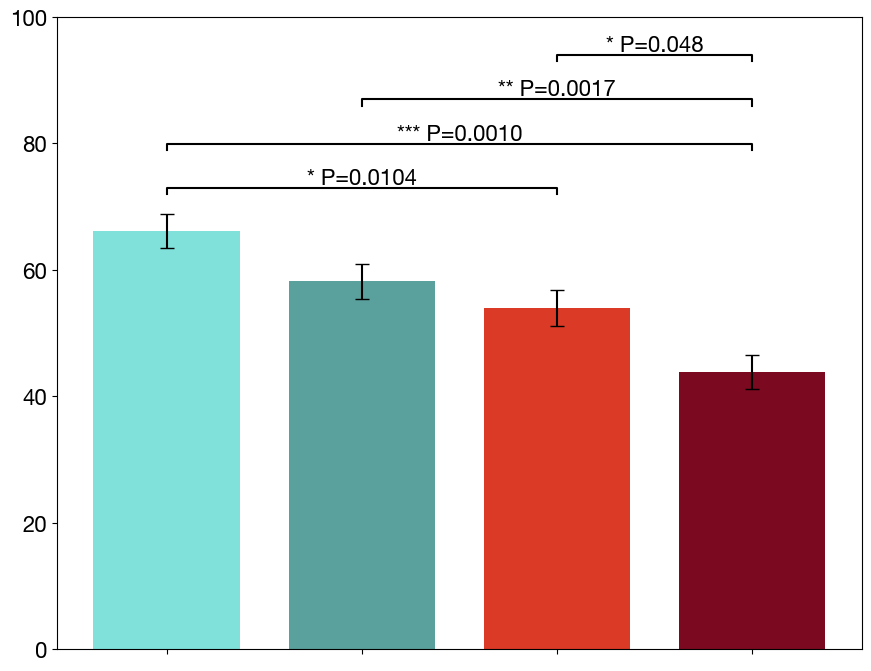

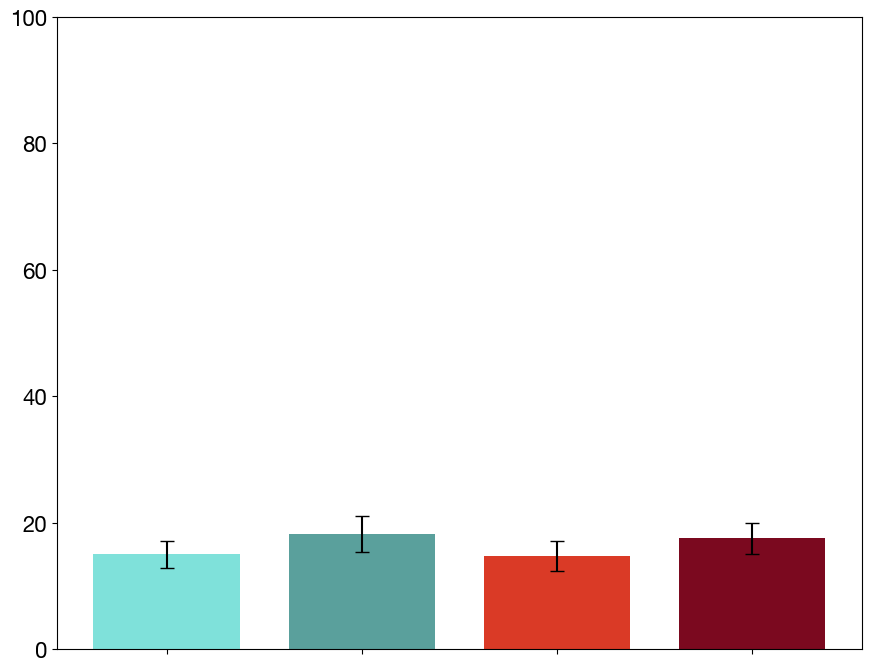

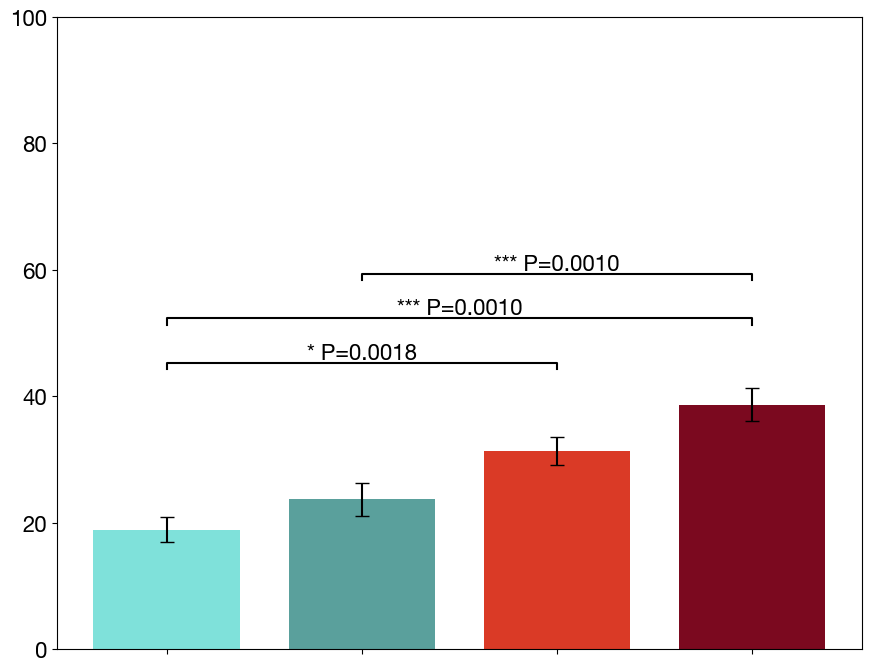

In [915]:
import matplotlib

# ordered_labels = ['Unedited Images', 'AI-Generated Videos\nof Unedited Images', 'AI-Edited Images', 'AI-Generated Videos\nof AI-Edited Images']
ordered_labels = ['', '', '', '']

# X positions
x_pos = np.arange(len(conditions))

#            1         2         3         4
# 1  1.000000  0.176505  0.010405  0.001000
# 2  0.176505  1.000000  0.671078  0.001700
# 3  0.010405  0.671078  1.000000  0.048483
# 4  0.001000  0.001700  0.048483  1.000000

#            1         2         3         4
# 1  1.000000  0.773965  0.900000  0.880243
# 2  0.773965  1.000000  0.726956  0.900000
# 3  0.900000  0.726956  1.000000  0.834302
# 4  0.880243  0.900000  0.834302  1.000000

#            1         2         3         4
# 1  1.000000  0.501394  0.001785  0.001000
# 2  0.501394  1.000000  0.107982  0.001000
# 3  0.001785  0.107982  1.000000  0.140631
# 4  0.001000  0.001000  0.140631  1.000000

# Significance values (p-values) for the significance markers
significance_values = [[
    ((0, 2), '* P=0.0104'),
    ((0, 3), '*** P=0.0010'),
    ((1, 3), '** P=0.0017'),
    ((2, 3), '* P=0.048'),
], [], [
    ((0, 2), '* P=0.0018'),
    ((0, 3), '*** P=0.0010'),
    ((1, 3), '*** P=0.0010'),
]]

mark = ['Non-false', 'Uncertain', 'False']

matplotlib.rc('font', size=16)
plt.rcParams["font.family"] = 'Helvetica Neue'

for i in range(3):
    # Creating the bar plot with error bars
    curr_means = [means[j][i] for j in range(4)]
    curr_errors = [errors[j][i] for j in range(4)]
    
    plt.figure(figsize=(9, 7))
    bars = plt.bar(x_pos, curr_means, yerr=curr_errors, capsize=5, color=colors, width=0.75)
    # plt.title(f'Number of {mark[i]} Memories (out of 12)\nby Experimental Condition with Error Bars')
    # plt.ylabel(f'Number of {mark[i]} Memories')
    # plt.xlabel('Experimental Condition')
    plt.xticks(x_pos, ordered_labels)

    # Adding significance markers with p-values, separate and not overlapping
    y_base_offset = 3  # Base vertical offset for significance lines
    y_increment = 7  # Increment for each subsequent significance marker

    # Initialize the first y position above the highest bar
    current_y_position = max(curr_means) + max(curr_errors) + y_base_offset

    for idx, ((i, j), label) in enumerate(significance_values[i]):
        x1, x2 = x_pos[i], x_pos[j]
        # print("{1} and {2} with id: {0}".format(idx, x1, x2))
        y = current_y_position
        h, col = 1, 'k'
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        plt.text((x1 + x2) * 0.5, y + h, label, ha='center', va='bottom', color=col)
        current_y_position += y_increment  # Update the y position for the next marker

    # Adjust plot limits to make space for significance markers
    plt.ylim(0, 100) # current_y_position + y_increment

    # Improve layout
    plt.tight_layout()

    #plt.savefig('foo.png', bbox_inches='tight')

    # Show the plot
    plt.show()

In [916]:
# Prepare data for plotting according to the specified order and calculate mean and standard error
means = []
errors = []
sds = []

for condition in conditions:
    if condition in conf:
        values = conf[condition]
        el1, el2, el3 = [el[0] for el in values], [el[1] for el in values], [el[2] for el in values]
        mean = [np.mean(el1), np.mean(el2), np.mean(el3)]
        # Calculate the standard error as the error bar (standard deviation divided by the square root of the sample size)
        std = [np.std(el1), np.std(el2), np.std(el3)]
        error = [std[0] / np.sqrt(len(el1)), std[1] / np.sqrt(len(el2)), std[2] / np.sqrt(len(el3))]
        means.append(mean)
        sds.append(std)
        errors.append(error)
        
        # print(f"{condition}\n   mean: {[float(i) for i in mean]}\n    err: {[float(i) for i in error]}\n    std: {[float(i) for i in std]}")
        
for i in range(3):
    print(["non-false", "unsure", "false"][i])
    for c in conditions:
        # print(f"{c}\n  mean: {"{:.3f}".format(float(means[conditions.index(c)][i]))}\n  err: {"{:.3f}".format(float(errors[conditions.index(c)][i]))}\n  std: {"{:.3f}".format(float(sds[conditions.index(c)][i]))}")
        print(f"{c}: M={"{:.3f}".format(float(means[conditions.index(c)][i]))}, err={"{:.3f}".format(float(errors[conditions.index(c)][i]))}, std={"{:.3f}".format(float(sds[conditions.index(c)][i]))}")
        
# means, errors, sds

non-false
control: M=3.685, err=0.174, std=1.221
ai-edited-video: M=3.333, err=0.191, std=1.348
ai-edited-image: M=2.894, err=0.176, std=1.260
ai-edited-image-video: M=2.470, err=0.172, std=1.219
unsure
control: M=0.587, err=0.088, std=0.615
ai-edited-video: M=0.708, err=0.120, std=0.852
ai-edited-image: M=0.544, err=0.083, std=0.592
ai-edited-image-video: M=0.657, err=0.100, std=0.707
false
control: M=1.014, err=0.121, std=0.846
ai-edited-video: M=1.270, err=0.142, std=1.007
ai-edited-image: M=1.577, err=0.117, std=0.837
ai-edited-image-video: M=2.217, err=0.172, std=1.213


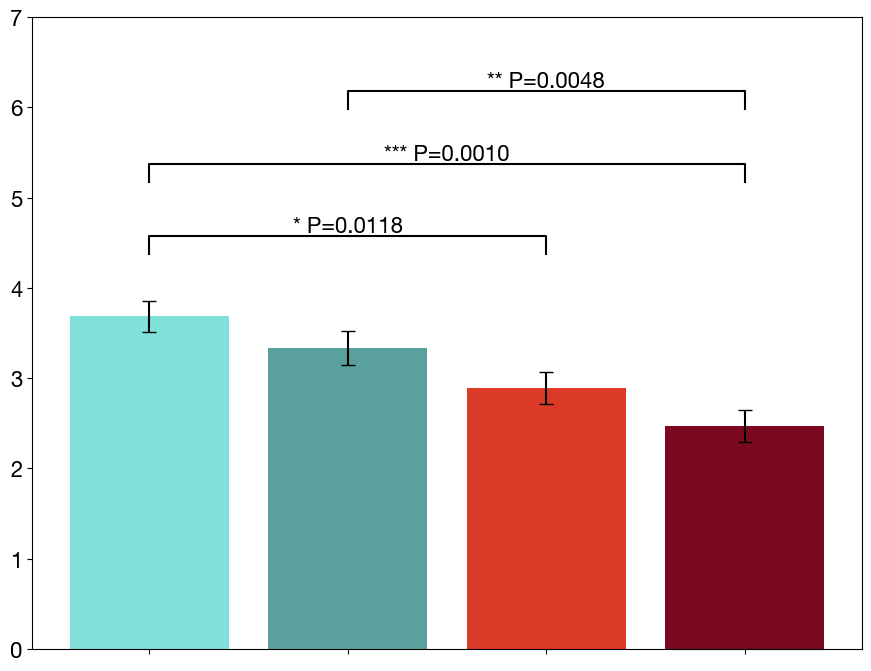

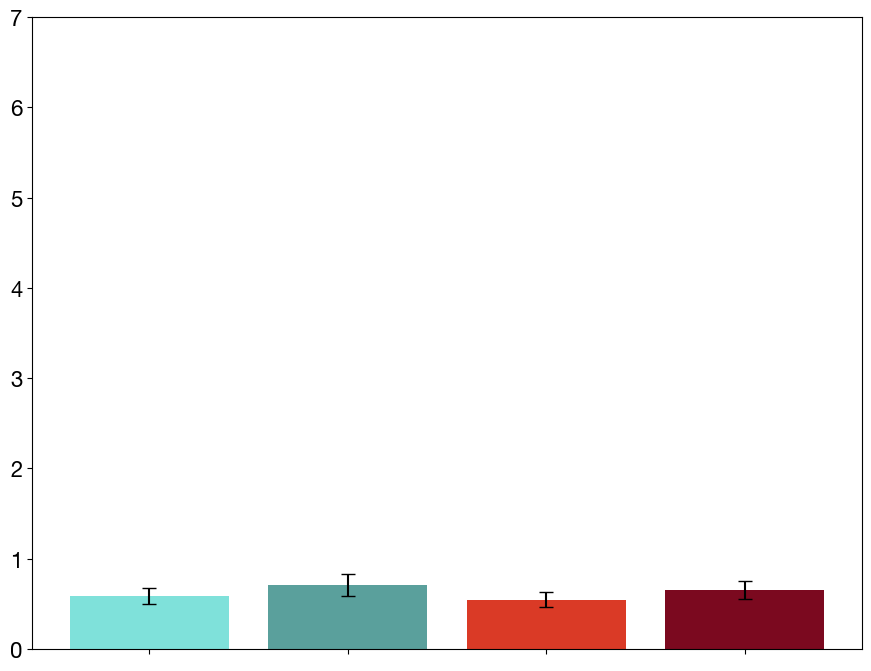

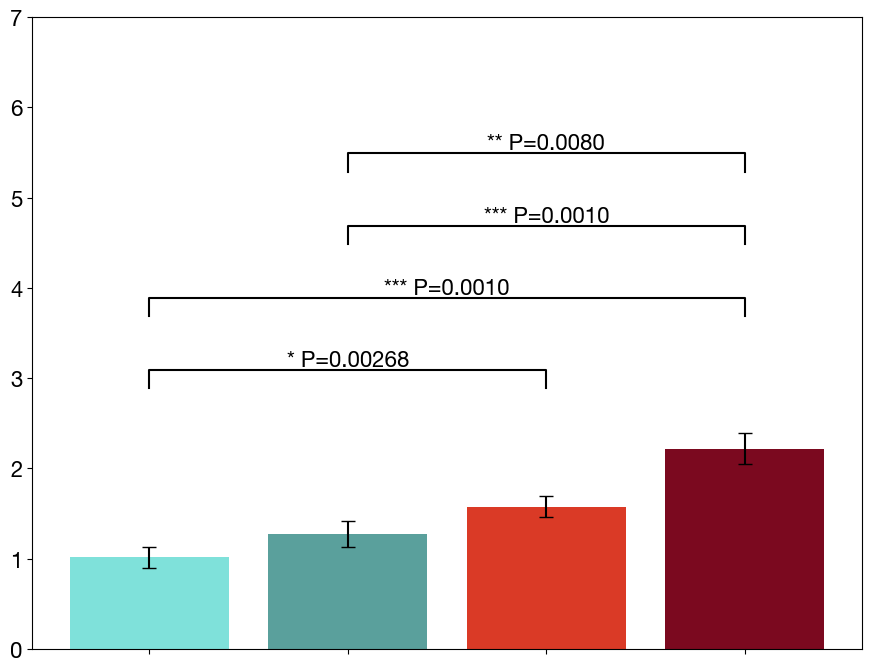

In [917]:
# ordered_labels = ['Unedited Images', 'AI-Generated Videos\nof Unedited Images', 'AI-Edited Images', 'AI-Generated Videos\nof AI-Edited Images']
ordered_labels = ['', '', '', '']
colors = ["#7FE1DA", "#5AA09C", "#DA3A26", "#7B091F"]

 # X positions
x_pos = np.arange(len(conditions))

# non-false
#           1         2         3         4
# 1  1.000000  0.516155  0.011792  0.001000
# 2  0.516155  1.000000  0.310829  0.004778
# 3  0.011792  0.310829  1.000000  0.343481
# 4  0.001000  0.004778  0.343481  1.000000

# unsure
#           1         2         3         4
# 1  1.000000  0.804508  0.900000  0.900000
# 2  0.804508  1.000000  0.629879  0.900000
# 3  0.900000  0.629879  1.000000  0.835745
# 4  0.900000  0.900000  0.835745  1.000000

# false
#           1         2         3         4
# 1  1.000000  0.568475  0.026769  0.001000
# 2  0.568475  1.000000  0.413799  0.001000
# 3  0.026769  0.413799  1.000000  0.008026
# 4  0.001000  0.001000  0.008026  1.000000

# Significance values (p-values) for the significance markers
significance_values = [[
    ((0, 2), '* P=0.0118'),
    ((0, 3), '*** P=0.0010'),
    ((1, 3), '** P=0.0048'),
], [], [
    ((0, 2), '* P=0.00268'),
    ((0, 3), '*** P=0.0010'),
    ((1, 3), '*** P=0.0010'),
    ((1, 3), '** P=0.0080'),
]]

mark = ['Non-false', 'Uncertain', 'False']

for i in range(3):
    # Creating the bar plot with error bars
    curr_means = [means[j][i] for j in range(4)]
    curr_errors = [errors[j][i] for j in range(4)]
    
    plt.figure(figsize=(9, 7))
    bars = plt.bar(x_pos, curr_means, yerr=curr_errors, capsize=5, color=colors)
    # plt.title(f'{mark[i]} Recallation Confidence\nby Experimental Condition with Error Bars')
    # plt.ylabel('Confidence Level')
    # plt.xlabel('Experimental Condition')
    plt.xticks(x_pos, ordered_labels)

    # Adding significance markers with p-values, separate and not overlapping
    y_base_offset = 0.5  # Base vertical offset for significance lines
    y_increment = 0.8  # Increment for each subsequent significance marker

    # Initialize the first y position above the highest bar
    current_y_position = max(curr_means) + max(curr_errors) + y_base_offset

    for idx, ((i, j), label) in enumerate(significance_values[i]):
        x1, x2 = x_pos[i], x_pos[j]
        # print("{1} and {2} with id: {0}".format(idx, x1, x2))
        y = current_y_position
        h, col = 0.2, 'k'
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        plt.text((x1 + x2) * 0.5, y + h, label, ha='center', va='bottom', color=col)
        current_y_position += y_increment  # Update the y position for the next marker

    # Adjust plot limits to make space for significance markers
    plt.ylim(0, 7) # current_y_position + y_increment

    # Improve layout
    plt.tight_layout()

    #plt.savefig('foo.png', bbox_inches='tight')

    # Show the plot
    plt.show()

In [918]:
n = 9

result[['condition', f"{n}_false_memories_ans", f"{n}_false_memories_conf"]]

# multiply 1_false_memories_ans by 1_false_memories_conf and retain condition
s = result[['condition', f"{n}_false_memories_ans", f"{n}_false_memories_conf"]].copy()
s['score'] = s[f'{n}_false_memories_ans'] * s[f'{n}_false_memories_conf']

s[f"{n}_false_memories_ans"] = s[f"{n}_false_memories_ans"].replace(1, 0)
s[f"{n}_false_memories_ans"] = s[f"{n}_false_memories_ans"].replace(-1, 1)

s.groupby('condition').sum()

,9_false_memories_ans,9_false_memories_conf,score
condition,,,
ai-edited-image,20,261,58
ai-edited-image-video,17,254,54
ai-edited-video,9,277,190
control,3,271,213


In [919]:
def prepare(data):
    # Prepare data for plotting according to the specified order and calculate mean and standard error
    means = []
    errors = []
    sds = []
    condition_dict = {
        'control': data[0],
        'ai-edited-video': data[1],
        'ai-edited-image': data[2],
        'ai-edited-image-video': data[3]
    }

    for condition in conditions:
        if condition in condition_dict:
            values = condition_dict[condition]
            mean = np.mean(values)
            # Calculate the standard error as the error bar (standard deviation divided by the square root of the sample size)
            std = np.std(values)
            error = np.std(values) / np.sqrt(len(values))
            means.append(mean)
            sds.append(std)
            errors.append(error)
            
            print(f"{condition}: M={"{:.3f}".format(mean)}, err={"{:.3f}".format(error)}, s.d.={"{:.3f}".format(std)}")

    return [means, errors, sds]
    # means, errors, sds
    
def plot(data, sig):
    ordered_labels = ['', '', '', '']
    colors = ["#7FE1DA", "#5AA09C", "#DA3A26", "#7B091F"]

    # X positions
    x_pos = np.arange(len(conditions))

    # *    P ≤ 0.05
    # **   P ≤ 0.01
    # ***  P ≤ 0.001
    # **** P ≤ 0.0001

    #           1         2         3         4
    # 1  1.000000  0.396745  0.002962  0.001000
    # 2  0.396745  1.000000  0.210558  0.001000
    # 3  0.002962  0.210558  1.000000  0.030136
    # 4  0.001000  0.001000  0.030136  1.000000

    # Significance values (p-values) for the significance markers
    # significance_values = [
    #     ((0, 2), '** P=0.0030'),
    #     ((0, 3), '*** P=0.0010'),
    #     ((1, 3), '*** P=0.0010'),
    #     ((2, 3), '* P=0.0301'),
    # ]

    stars = [0.0001, 0.001, 0.01, 0.05]
    significance_values = []
    for s in sig:
        [val, ii, jj] = s
        star = "*"
        if(val <= 0.0001): star = "****"
        elif(val <= 0.001): star = "***"
        elif(val <= 0.01): star = "**"
        significance_values.append(((ii-1,jj-1), f"{star} P={"{:.5f}".format(val)}"))
        

    [means, errors, sds] = prepare(data)

    # Creating the bar plot with error bars
    plt.figure(figsize=(9, 7))
    bars = plt.bar(x_pos, means, yerr=errors, capsize=5, color=colors)
    # plt.title('Recollection Score by Experimental Condition with Error Bars')
    # plt.ylabel('Average Score')
    # plt.xlabel('Experimental Condition')
    plt.xticks(x_pos, ordered_labels)

    # Adding significance markers with p-values, separate and not overlapping
    y_base_offset = 3  # Base vertical offset for significance lines
    y_increment = 7  # Increment for each subsequent significance marker

    # Initialize the first y position above the highest bar
    current_y_position = max(means) + max(errors) + y_base_offset

    for idx, ((i, j), label) in enumerate(significance_values):
        x1, x2 = x_pos[i], x_pos[j]
        # print("{1} and {2} with id: {0}".format(idx, x1, x2))
        y = current_y_position
        h, col = 1, 'k'
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        plt.text((x1 + x2) * 0.5, y + h, label, ha='center', va='bottom', color=col)
        current_y_position += y_increment  # Update the y position for the next marker

    # Adjust plot limits to make space for significance markers
    plt.ylim(0, 80)

    # Improve layout
    plt.tight_layout()

    #plt.savefig('foo.png', bbox_inches='tight')

    # Show the plot
    plt.show()

military
------------------------------
SHAPIRO-WILK
control => ShapiroResult(statistic=np.float64(0.7451262691522436), pvalue=np.float64(7.32788598804197e-08))
ai-edited-video => ShapiroResult(statistic=np.float64(0.7523834863697588), pvalue=np.float64(8.231717524472121e-08))
ai-edited-image => ShapiroResult(statistic=np.float64(0.8181245211626), pvalue=np.float64(1.955864653382467e-06))
ai-edited-image-video => ShapiroResult(statistic=np.float64(0.8376083569679291), pvalue=np.float64(7.264877259257067e-06))

KRUSKAL-WALLIS => KruskalResult(statistic=np.float64(21.95221291937286), pvalue=np.float64(6.674173923025e-05))

DUNN
          1         2         3         4
1  1.000000  0.895409  0.126445  0.000040
2  0.895409  1.000000  0.160514  0.000064
3  0.126445  0.160514  1.000000  0.008990
4  0.000040  0.000064  0.008990  1.000000
       1      2      3      4
1  False  False  False   True
2  False  False  False   True
3  False  False  False   True
4   True   True   True  False
contro

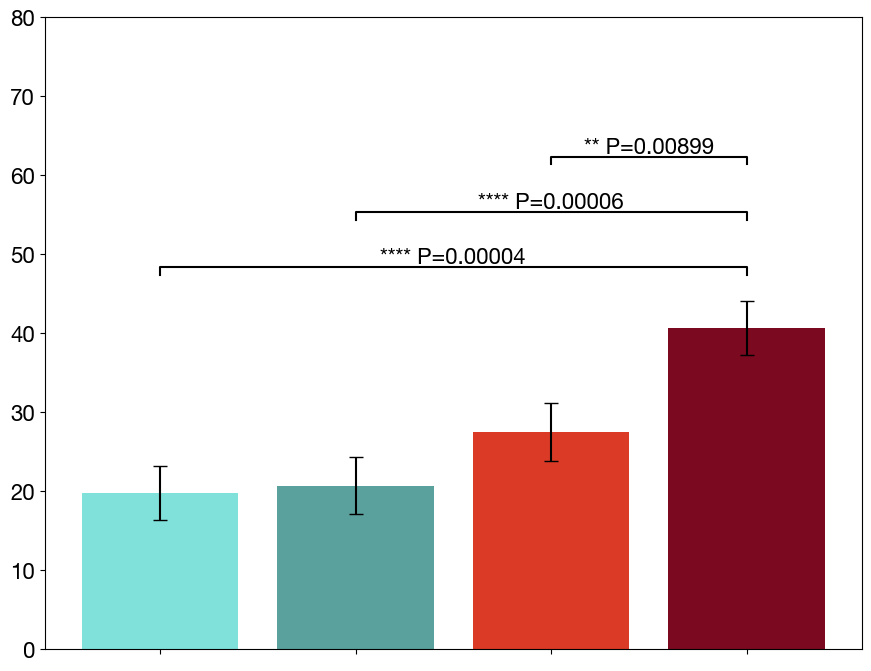



environment
------------------------------
SHAPIRO-WILK
control => ShapiroResult(statistic=np.float64(0.5439137756711445), pvalue=np.float64(4.1143179622781614e-11))
ai-edited-video => ShapiroResult(statistic=np.float64(0.7004230477887039), pvalue=np.float64(8.422003327721089e-09))
ai-edited-image => ShapiroResult(statistic=np.float64(0.7629227992140188), pvalue=np.float64(1.0978277859150512e-07))
ai-edited-image-video => ShapiroResult(statistic=np.float64(0.8197555429661677), pvalue=np.float64(2.58044258886025e-06))

KRUSKAL-WALLIS => KruskalResult(statistic=np.float64(25.120851027714412), pvalue=np.float64(1.4567701645750872e-05))

DUNN
          1         2         3         4
1  1.000000  0.118070  0.000549  0.000004
2  0.118070  1.000000  0.058099  0.002026
3  0.000549  0.058099  1.000000  0.227531
4  0.000004  0.002026  0.227531  1.000000
       1      2      3      4
1  False  False   True   True
2  False  False  False   True
3   True  False  False  False
4   True   True  Fals

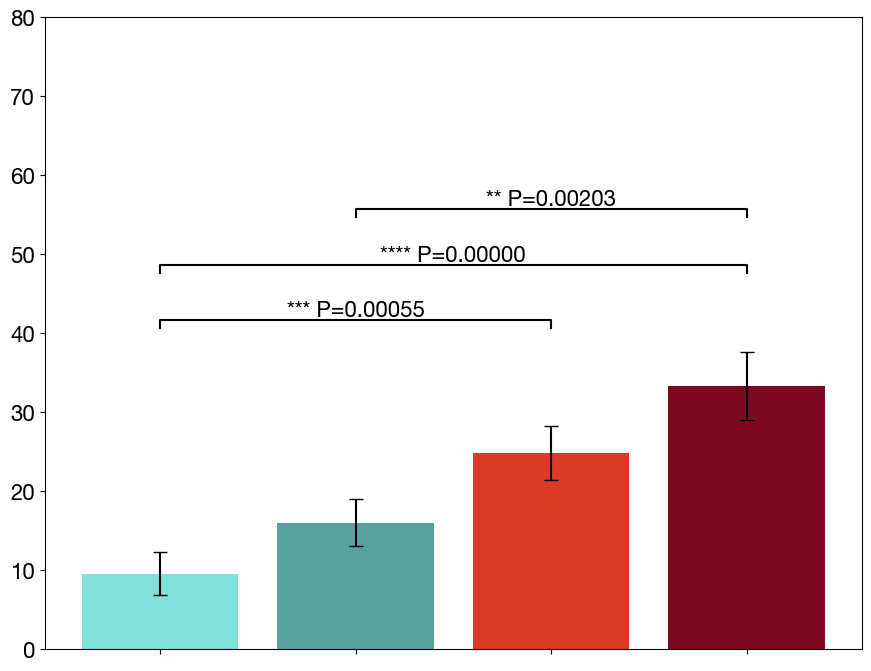



feature
------------------------------
SHAPIRO-WILK
control => ShapiroResult(statistic=np.float64(0.7264404258250288), pvalue=np.float64(3.194835802543888e-08))
ai-edited-video => ShapiroResult(statistic=np.float64(0.791953183608185), pvalue=np.float64(5.750010179965216e-07))
ai-edited-image => ShapiroResult(statistic=np.float64(0.867750329746965), pvalue=np.float64(4.1476721421256284e-05))
ai-edited-image-video => ShapiroResult(statistic=np.float64(0.8722043943148196), pvalue=np.float64(6.5448188360209e-05))

KRUSKAL-WALLIS => KruskalResult(statistic=np.float64(30.405335374884814), pvalue=np.float64(1.134012185205854e-06))

DUNN
          1         2         3         4
1  1.000000  0.352672  0.000060  0.000005
2  0.352672  1.000000  0.001968  0.000267
3  0.000060  0.001968  1.000000  0.569418
4  0.000005  0.000267  0.569418  1.000000
       1      2      3      4
1  False  False   True   True
2  False  False   True   True
3   True   True  False  False
4   True   True  False  False


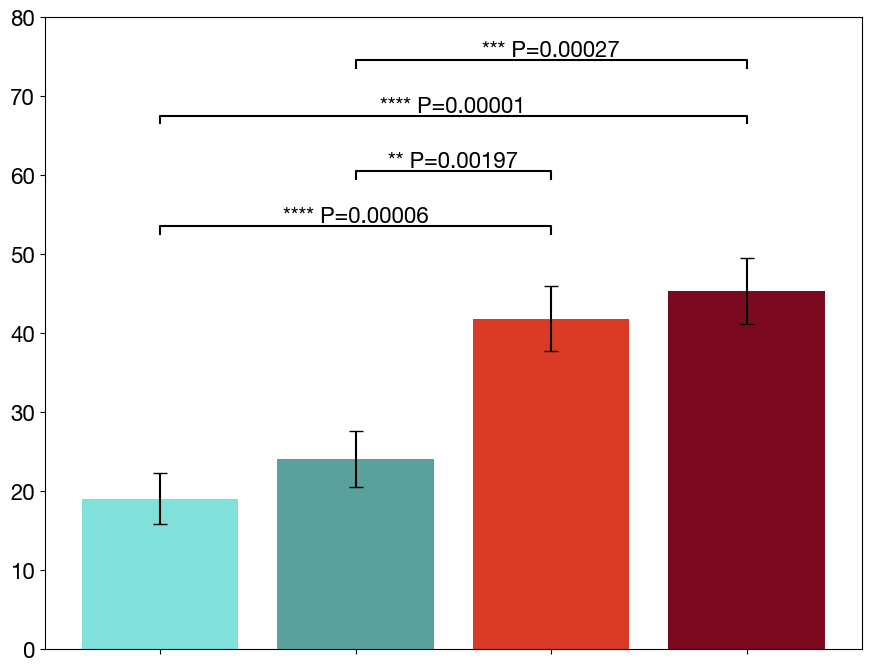



smile
------------------------------
SHAPIRO-WILK
control => ShapiroResult(statistic=np.float64(0.6354901158492852), pvalue=np.float64(8.77774729279962e-10))
ai-edited-video => ShapiroResult(statistic=np.float64(0.6221274434800383), pvalue=np.float64(4.2099013163800654e-10))
ai-edited-image => ShapiroResult(statistic=np.float64(0.6366562589957097), pvalue=np.float64(5.520687759238644e-10))
ai-edited-image-video => ShapiroResult(statistic=np.float64(0.6315708772127204), pvalue=np.float64(5.903966288826652e-10))

KRUSKAL-WALLIS => KruskalResult(statistic=np.float64(2.2001855740288887), pvalue=np.float64(0.5319118198385675))

DUNN
          1         2         3         4
1  1.000000  0.194083  0.835311  0.367641
2  0.194083  1.000000  0.270163  0.689364
3  0.835311  0.270163  1.000000  0.483307
4  0.367641  0.689364  0.483307  1.000000
       1      2      3      4
1  False  False  False  False
2  False  False  False  False
3  False  False  False  False
4  False  False  False  False
co

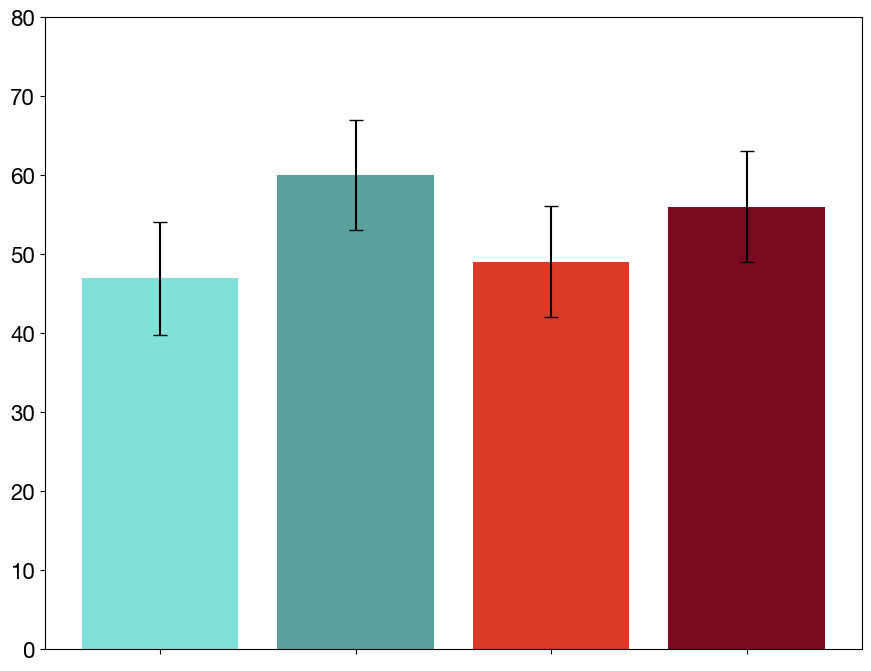

In [920]:
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn

def testset(n):
    # amount = {
    #     "control": 49,
    #     "ai-edited-image": 51,
    #     "ai-edited-image-video": 50,
    #     "ai-edited-video": 50
    # }

    s = result[['condition', *[f"{i}_false_memories_ans" for i in n]]].copy()

    for i in n:
        s[f"{i}_false_memories_ans"] = s[f"{i}_false_memories_ans"].replace(1, 0)
        s[f"{i}_false_memories_ans"] = s[f"{i}_false_memories_ans"].replace(-1, 1)

    s['sum'] = s[[f"{i}_false_memories_ans" for i in n]].sum(axis=1)

    # s = s.groupby('condition').sum().to_dict()['sum']
    # for a in amount:
    #     s[a] = s[a] / (amount[a] * len(n)) * 100
    #     
    # s

    data = []

    for c in conditions:
        m = s[s['condition'] == c]['sum']
        data.append([el * 100 / len(n) for el in m.tolist()])
        
    # print(data)

    print("SHAPIRO-WILK")
    for i in range(4):
        print(conditions[i], "=>", shapiro(data[i]))

    print("\nKRUSKAL-WALLIS", "=>", kruskal(*data))

    print("\nDUNN")
    print(posthoc_dunn(data))
    print(posthoc_dunn(data) < 0.05)
    
    sig = []
    dunn_dict = posthoc_dunn(data).to_dict()
    
    for ii in range(2,5):
        for jj in range(1,5):
            if(ii > jj and dunn_dict[ii][jj] < 0.05):
                sig.append([dunn_dict[ii][jj], ii, jj])
    
    plot(data, sig)
    
sets = {
    "military": [10,11,12],
    "environment": [2,17,20],
    "feature": [3,9,18],
    "smile": [1]
}

for i in sets:
    print(i+"\n"+"-"*30)
    testset(sets[i])
    print("\n")
